In [57]:
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns   
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
sns.set_theme(style="darkgrid")

In [58]:
from sklearn.metrics import matthews_corrcoef,f1_score, precision_score, recall_score

def Graficar_MC(mc):
    plt.figure(figsize=(10, 7))
    sns.heatmap(mc, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.show()

def mostrar_metricas(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    mc = confusion_matrix(y_test, y_pred)
    Graficar_MC(mc)
    
def Guardar_metricas(resultados_modelos, grid_search, y_test, y_pred,modelo,estado):
    resultados_modelos.append({
    'Modelo': modelo,
    'situación': estado,
    'Mejores Parámetros': grid_search.best_params_,
    'Mejor Accuracy (validación)': grid_search.best_score_,
    'Accuracy (test)': accuracy_score(y_test, y_pred),
    'F1-Score (test)': f1_score(y_test, y_pred),
    'Matthews Correlation Coefficient (test)': matthews_corrcoef(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred, average='weighted')

})

### Leer archivos csv y agregarlos en un diccionario

Se organiza de tal manera de que de un diccionario tenga <br>
```python
dfs = {nombre_archivo1:{dataframe1} , nombre_archivo2:{dataframe2} , ... , nombre_archivo_n:{dataframe_n} }
```


In [59]:
path = "archivos"
dfs = {}
for file in os.scandir(path):
    if file.is_file() and file.name.endswith('.csv'):
        name = os.path.splitext(file.name)[0]  
        dfs[name] = pd.read_csv(file).drop(columns='Unnamed: 0')

### Hacemos una pequenia limpieza de datos
##### Eliminamos alguna columna grupo que es nula y filas que tienen datos nulos

In [60]:
for name, df in dfs.items():
    df.dropna(axis='columns', how = 'all',inplace=True)
    #df['banda'] = df['Banda'].str.replace('(1)', '', regex=False)
    df.dropna(axis='rows', how = 'any',inplace=True)
    df.reset_index(drop=True, inplace=True)
    if 'random' in name.lower():
        df['Real'] = 0
    else:
        df['Real'] = 1    

In [61]:
dfs_Randoms = {}
dfs_Real = {}

for name, df in dfs.items():
    # si el nombre del archivo contiene 'RANDOM',  y agregar una columna de clasificacion, si es una pareja random con 0 y 1 
    if 'RANDOM' in name: 
        dfs_Randoms[name] = df
    else:
        dfs_Real[name] = df
# Imprimir los nombres de los DataFrames
print("DataFrames con 'RANDOM':", list(dfs_Randoms.keys()))
print("DataFrames sin 'Real':", list(dfs_Real.keys()))

DataFrames con 'RANDOM': ['CORR-RANDOM_OA', 'CORR-RANDOM_OC', 'CORR-RANDOM_EX']
DataFrames sin 'Real': ['CORR_EX', 'CORR_OC', 'CORR_OA']


Empezamos a hacer modelos para los todos los datos juntos

In [62]:
dfs_total_Random = pd.concat(dfs_Randoms.values(), ignore_index=True)
dfs_total_Random = dfs_total_Random.sample(frac=1, random_state=1984).reset_index(drop=True)
#display(dfs_total_Random)

df_Random = dfs_total_Random.iloc[:len(dfs_total_Random)//4]  
#display(df_Random)

In [63]:

#df_total = pd.concat(list(dfs_Randoms.values()) + list(dfs_Real.values()) , ignore_index=True)
resultados_modelos = []

df_total = pd.concat([df_Random] + list(dfs_Real.values()), ignore_index=True)
df_total['Banda'] = df_total['Banda'].str.replace('(1)', '', regex=False)
#display(df_total)
y = df_total['Real']
X = df_total.drop(columns=['Real','Tipo','Condicion','Banda','Participantes','Grupo'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


logistic_model = LogisticRegression()

# Define the parameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],               
    'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
    'solver': ['saga']  
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='matthews_corrcoef', n_jobs=-1)


/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

Accuracy: 0.5665859564164649
Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.72       234
           1       0.00      0.00      0.00       179

    accuracy                           0.57       413
   macro avg       0.28      0.50      0.36       413
weighted avg       0.32      0.57      0.41       413

Matthews Correlation Coefficient: 0.0
F1 Score: 0.40983342751608276
Precision: 0.3210196460083603
Recall: 0.5665859564164649


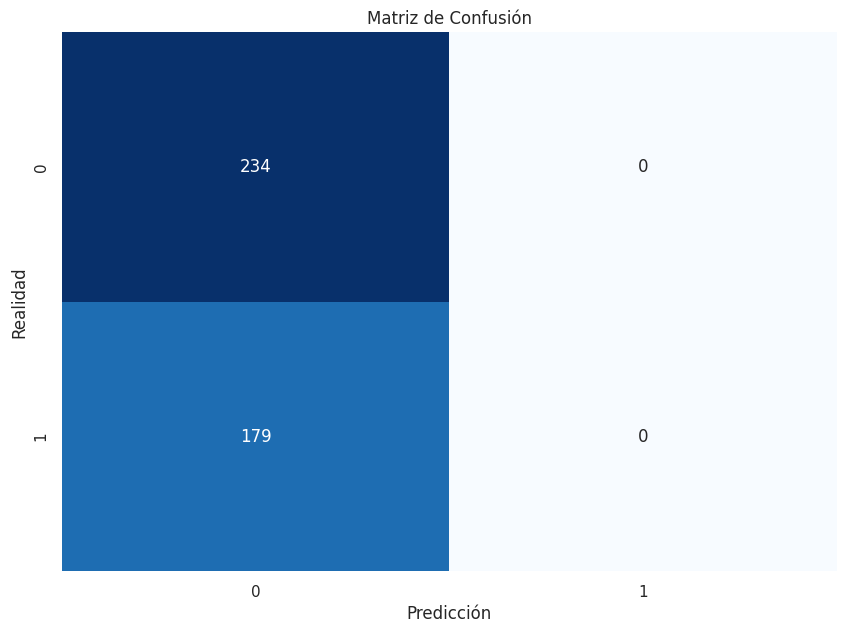

In [64]:
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
Guardar_metricas(resultados_modelos, grid_search, y_test, y_pred, 'Logistic Regression', 'Totales')
mostrar_metricas(y_test, y_pred)

In [65]:
display(pd.DataFrame(resultados_modelos))

,Modelo,situación,Mejores Parámetros,Mejor Accuracy (validación),Accuracy (test),F1-Score (test),Matthews Correlation Coefficient (test),Recall
0,Logistic Regression,Totales,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.0,0.566586,0.0,0.0,0.566586


### Armar modelos de regresión logística para cada Banda


Banda: DL
Accuracy: 0.5192307692307693
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.45      0.51        29
           1       0.47      0.61      0.53        23

    accuracy                           0.52        52
   macro avg       0.53      0.53      0.52        52
weighted avg       0.54      0.52      0.52        52

Matthews Correlation Coefficient: 0.05727283904934167
F1 Score: 0.5179857138791656
Precision: 0.5359557109557109
Recall: 0.5192307692307693


/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

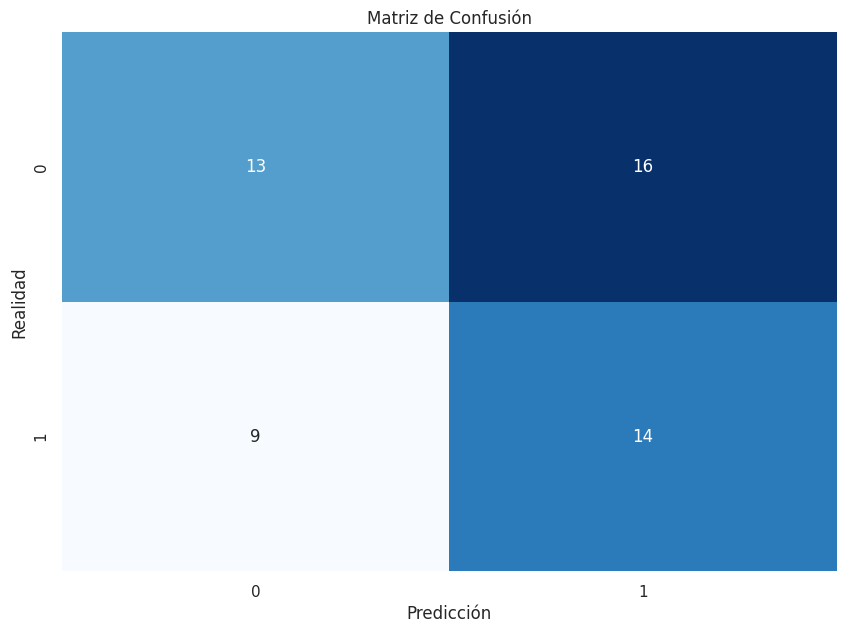

/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

Banda: BT
Accuracy: 0.4827586206896552
Classification Report:
               precision    recall  f1-score   support

           0       0.48      1.00      0.65        28
           1       0.00      0.00      0.00        30

    accuracy                           0.48        58
   macro avg       0.24      0.50      0.33        58
weighted avg       0.23      0.48      0.31        58

Matthews Correlation Coefficient: 0.0
F1 Score: 0.3143544506816359
Precision: 0.23305588585017836
Recall: 0.4827586206896552


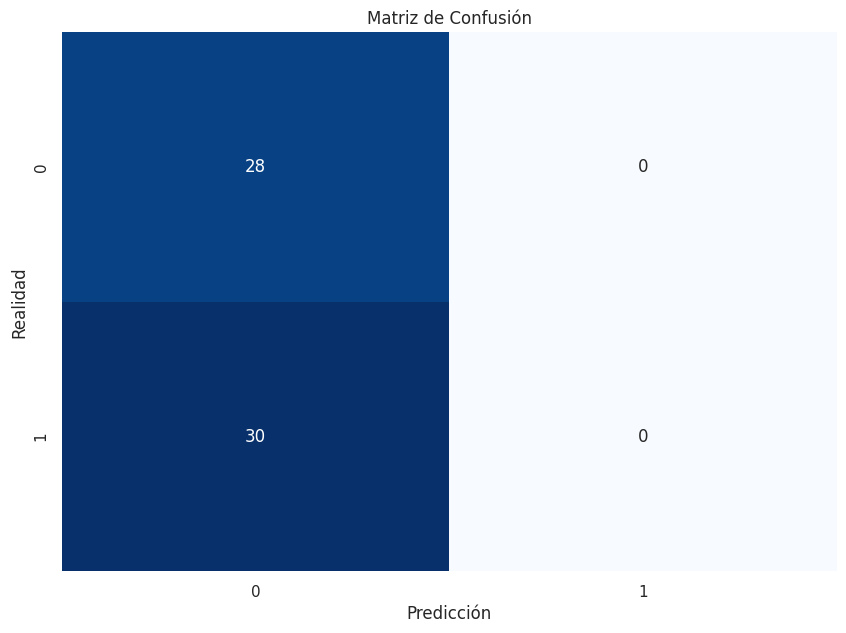

Banda: AL1
Accuracy: 0.45454545454545453
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.41      0.46        32
           1       0.39      0.52      0.44        23

    accuracy                           0.45        55
   macro avg       0.46      0.46      0.45        55
weighted avg       0.48      0.45      0.46        55

Matthews Correlation Coefficient: -0.07162266797941799
F1 Score: 0.455988455988456
Precision: 0.4770283479960899
Recall: 0.45454545454545453


/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

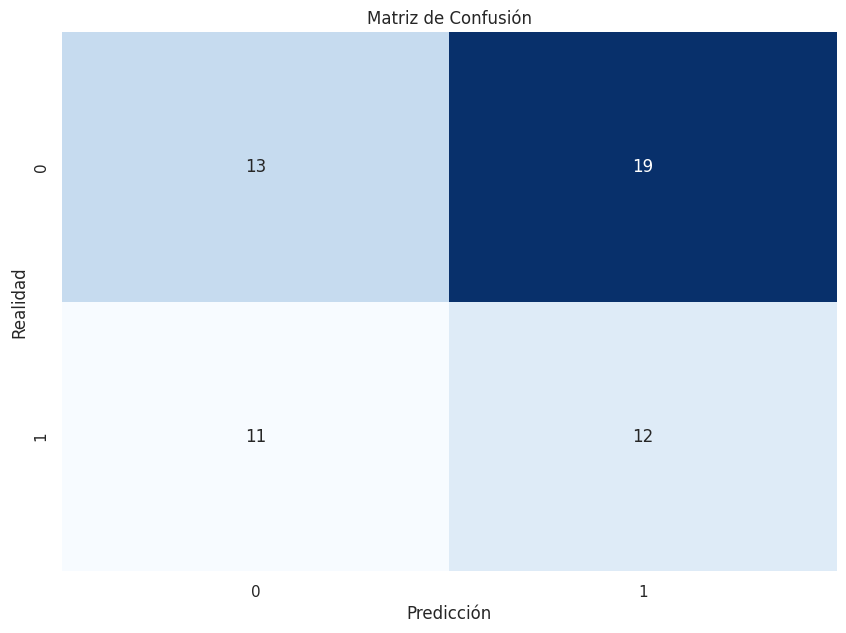

Banda: GM
Accuracy: 0.41818181818181815
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.48      0.38        21
           1       0.54      0.38      0.45        34

    accuracy                           0.42        55
   macro avg       0.43      0.43      0.42        55
weighted avg       0.46      0.42      0.42        55

Matthews Correlation Coefficient: -0.1385752912754208
F1 Score: 0.42396913431396194
Precision: 0.4580156402737047
Recall: 0.41818181818181815


/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

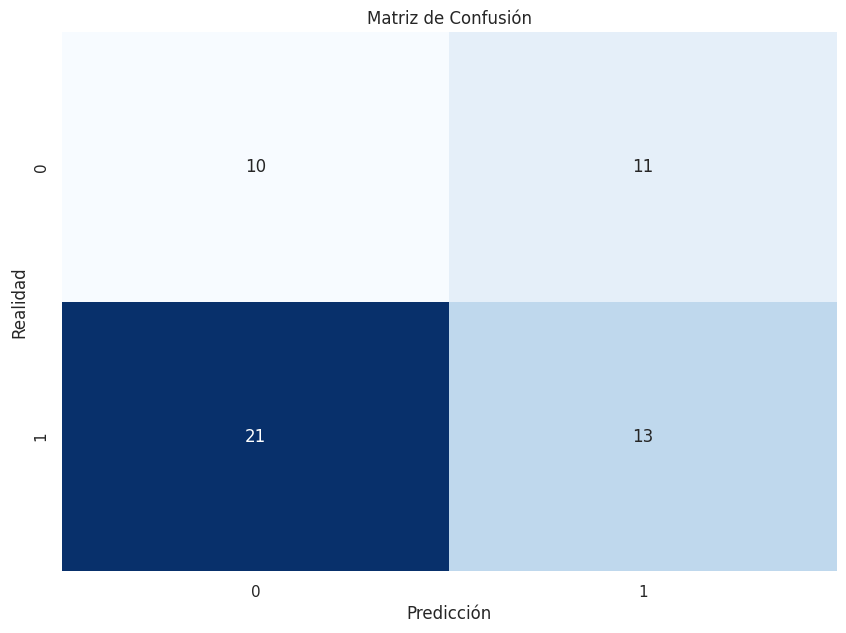

Banda: AL2
Accuracy: 0.5576923076923077
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.55      0.60        31
           1       0.46      0.57      0.51        21

    accuracy                           0.56        52
   macro avg       0.56      0.56      0.55        52
weighted avg       0.58      0.56      0.56        52

Matthews Correlation Coefficient: 0.11757927025044308
F1 Score: 0.5618198524133574
Precision: 0.5761834319526628
Recall: 0.5576923076923077


/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

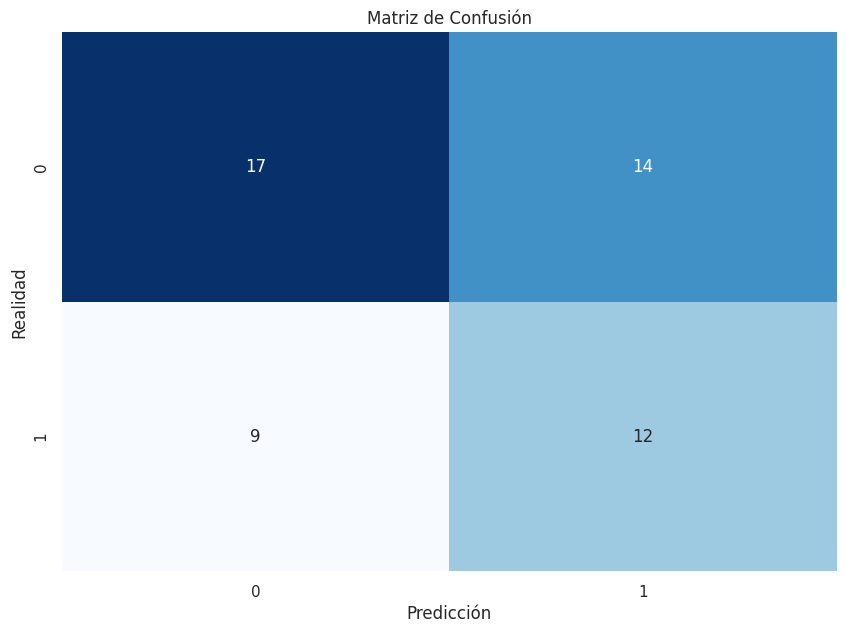

Banda: TH
Accuracy: 0.46
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.41      0.47        29
           1       0.39      0.52      0.45        21

    accuracy                           0.46        50
   macro avg       0.47      0.47      0.46        50
weighted avg       0.48      0.46      0.46        50

Matthews Correlation Coefficient: -0.06204182926262424
F1 Score: 0.4615126050420168
Precision: 0.4813636363636363
Recall: 0.46


/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

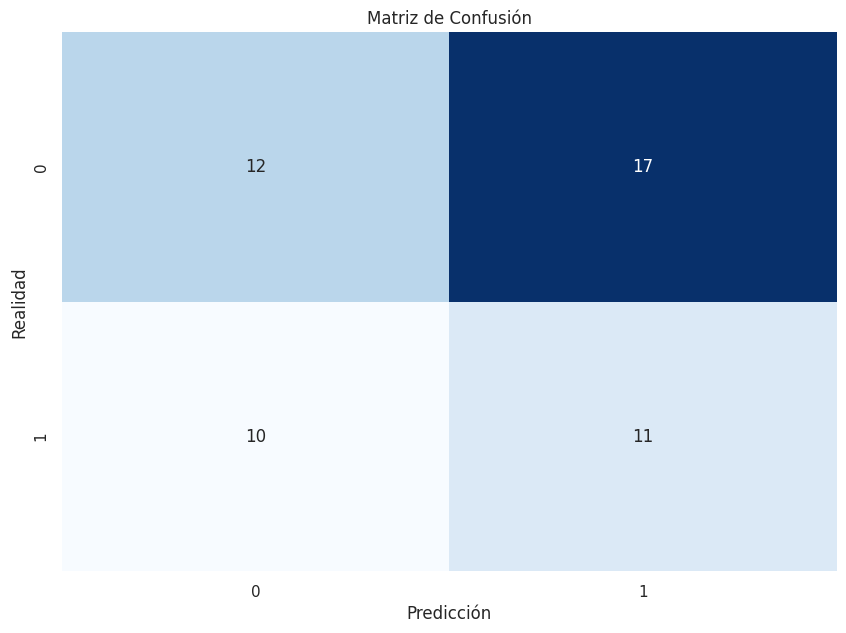

Banda: GM2
Accuracy: 0.6382978723404256
Classification Report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78        30
           1       0.00      0.00      0.00        17

    accuracy                           0.64        47
   macro avg       0.32      0.50      0.39        47
weighted avg       0.41      0.64      0.50        47

Matthews Correlation Coefficient: 0.0
F1 Score: 0.49737496546007187
Precision: 0.4074241738343142
Recall: 0.6382978723404256


/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

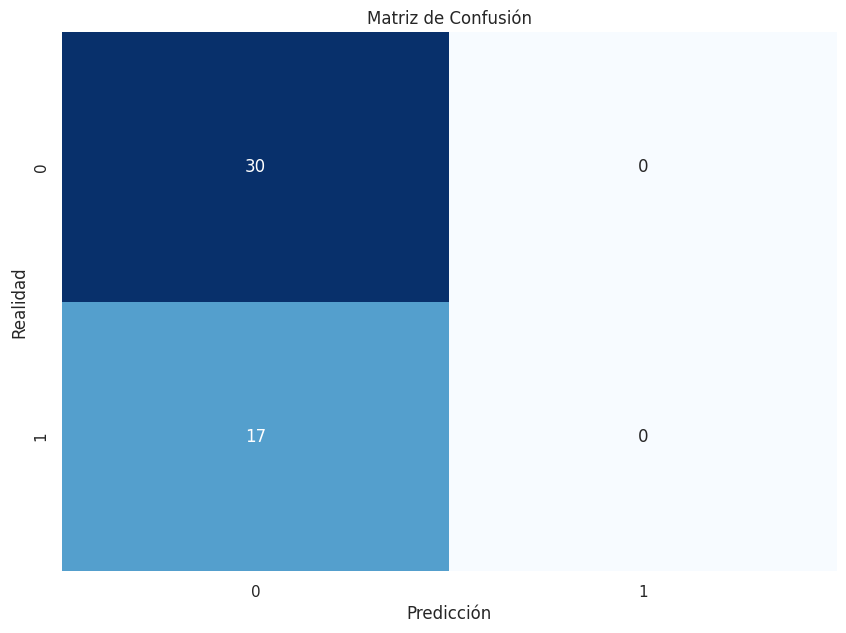

In [ ]:

lista_de_bandas = df_total['Banda'].unique()
lista_de_bandas = lista_de_bandas[:-1] # Excluir 'ALI(1)' de la lista, eliminando el ultimo elemote de la lista
for banda in lista_de_bandas:
    df_banda = df_total[df_total['Banda'] == banda]
    y_banda = df_banda['Real']
    X_banda = df_banda.drop(columns=['Real','Tipo','Condicion','Banda','Participantes','Grupo'])
    X_train_banda, X_test_banda, y_train_banda, y_test_banda = train_test_split(X_banda, y_banda, test_size=0.2)
    
    grid_search.fit(X_train_banda, y_train_banda)
    y_pred_banda = grid_search.predict(X_test_banda)
    
    print(f"Banda: {banda}")
    Guardar_metricas(resultados_modelos, grid_search, y_test_banda, y_pred_banda, 'Logistic Regression', 'Banda: ' + banda)
    mostrar_metricas(y_test_banda, y_pred_banda)

### Hacer modelos de regresion logistica por condicion de los EEG: EX,OA,OC

/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

Accuracy: 0.4878048780487805
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.55      0.59        83
           1       0.27      0.35      0.31        40

    accuracy                           0.49       123
   macro avg       0.46      0.45      0.45       123
weighted avg       0.52      0.49      0.50       123

Matthews Correlation Coefficient: -0.09107658581555209
F1 Score: 0.5005870604611753
Precision: 0.5203916254848823
Recall: 0.4878048780487805


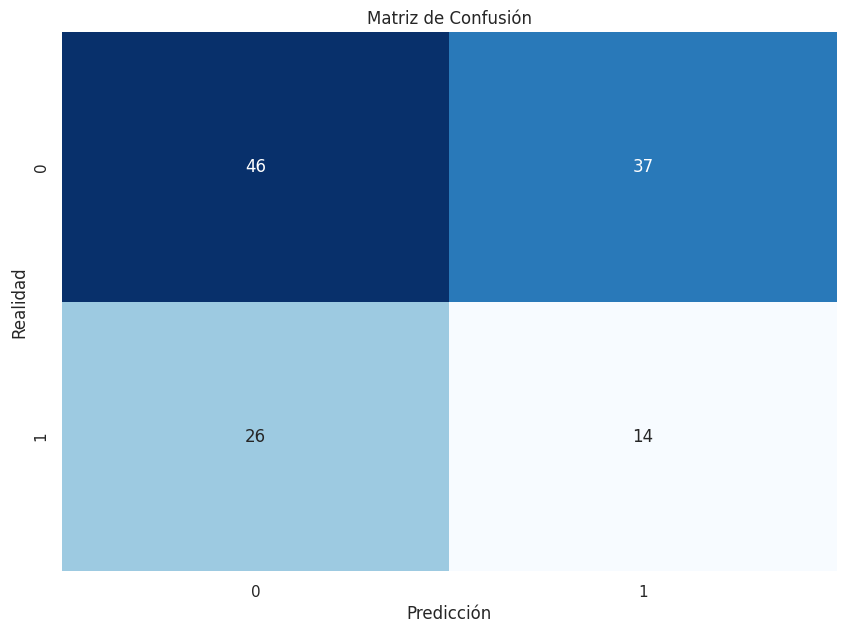

/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

Accuracy: 0.6014492753623188
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.65      0.63        71
           1       0.60      0.55      0.57        67

    accuracy                           0.60       138
   macro avg       0.60      0.60      0.60       138
weighted avg       0.60      0.60      0.60       138

Matthews Correlation Coefficient: 0.20107946996734638
F1 Score: 0.6005034976579104
Precision: 0.6011417041903496
Recall: 0.6014492753623188


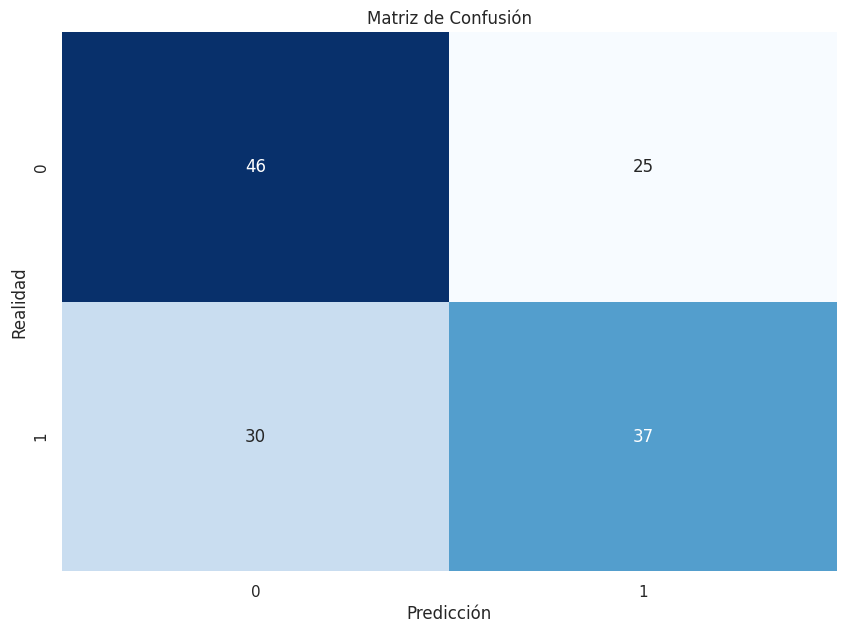

/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leo/Documents/Entornos_virtuales/EEG/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

Accuracy: 0.49019607843137253
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.37      0.43        82
           1       0.46      0.63      0.54        71

    accuracy                           0.49       153
   macro avg       0.50      0.50      0.49       153
weighted avg       0.50      0.49      0.48       153

Matthews Correlation Coefficient: -0.00035564279480764795
F1 Score: 0.48162018430560627
Precision: 0.5023968350226689
Recall: 0.49019607843137253


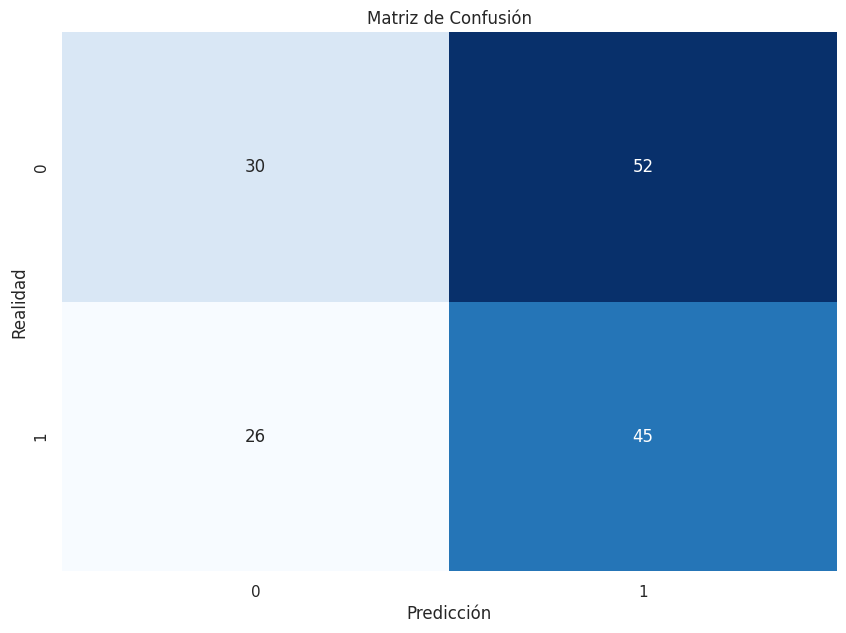

In [ ]:

lista_de_condiciones = df_total['Condicion'].unique()
for condicion in lista_de_condiciones:
    df_condicion = df_total[df_total['Condicion'] == condicion]
    y_condicion = df_condicion['Real']
    X_condicion = df_condicion.drop(columns=['Real','Tipo','Condicion','Banda','Participantes','Grupo'])
    X_train_condicion, X_test_condicion, y_train_condicion, y_test_condicion = train_test_split(X_condicion, y_condicion, test_size=0.2)
    
    grid_search.fit(X_train_condicion, y_train_condicion)
    y_pred_condicion = grid_search.predict(X_test_condicion)
    
    mostrar_metricas(y_test_condicion, y_pred_condicion)
    Guardar_metricas(resultados_modelos, grid_search, y_test_condicion, y_pred_condicion, 'Logistic Regression', 'Condicion: ' + condicion)


## Empezar modelos de SVM

##### Empezar por todo junto

In [68]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
svm = SVC()

scaler = StandardScaler()
pipeline = Pipeline([
    ('scaler', scaler),
    ('svc', svm)
])

param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svc__gamma': ['scale', 'auto'],
    'svc__degree': [2, 3, 4,10,15]  
}

grid_search_svm= GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='matthews_corrcoef', n_jobs=-1)

Accuracy: 0.639225181598063
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.61      0.66       238
           1       0.56      0.67      0.61       175

    accuracy                           0.64       413
   macro avg       0.64      0.64      0.64       413
weighted avg       0.65      0.64      0.64       413

Matthews Correlation Coefficient: 0.28440460963036185
F1 Score: 0.6413075759322733
Precision: 0.6525562884417356
Recall: 0.639225181598063


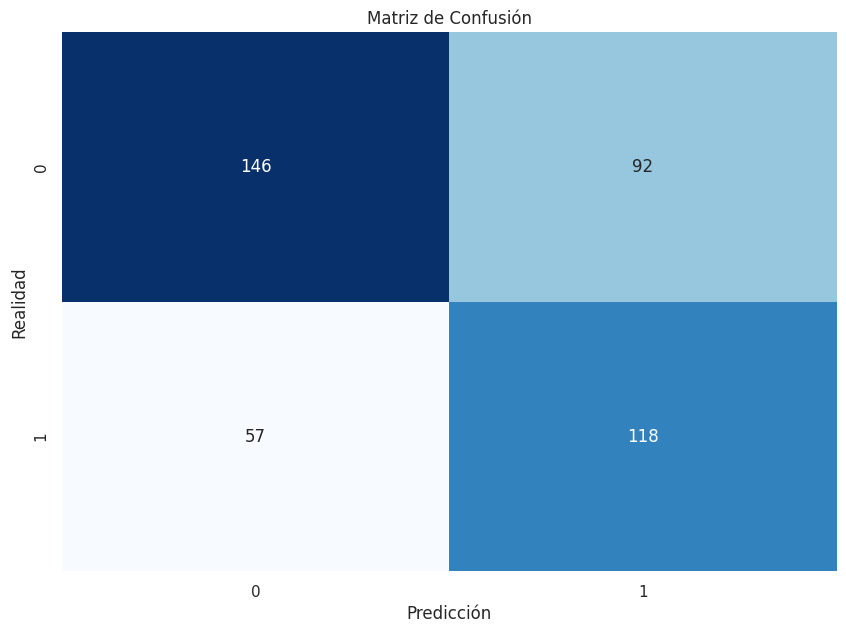

In [ ]:

y = df_total['Real']
X = df_total.drop(columns=['Real','Tipo','Condicion','Banda','Participantes','Grupo'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

grid_search_svm.fit(X_train,y_train)

y_pred_svm = grid_search_svm.predict(X_test)
mostrar_metricas(y_test, y_pred_svm)
Guardar_metricas(resultados_modelos, grid_search_svm, y_test, y_pred_svm, 'SVM', 'totales SVM')


In [70]:
display(grid_search_svm.best_params_)
display(grid_search_svm.best_score_)

{'svc__C': 10, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

np.float64(0.33929108435392824)

#### Hacer SVM por bandas

Banda: DL
Accuracy: 0.5576923076923077
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.37      0.47        27
           1       0.53      0.76      0.62        25

    accuracy                           0.56        52
   macro avg       0.58      0.57      0.54        52
weighted avg       0.58      0.56      0.54        52

Matthews Correlation Coefficient: 0.1411300658019085
F1 Score: 0.5409982697439808
Precision: 0.578258547008547
Recall: 0.5576923076923077


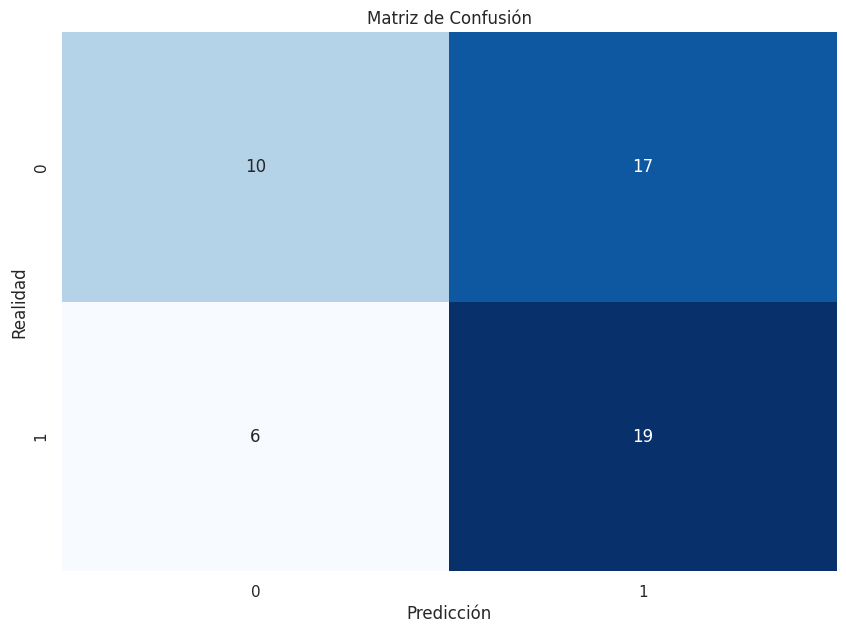

Banda: BT
Accuracy: 0.6551724137931034
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.65      0.67        31
           1       0.62      0.67      0.64        27

    accuracy                           0.66        58
   macro avg       0.66      0.66      0.65        58
weighted avg       0.66      0.66      0.66        58

Matthews Correlation Coefficient: 0.3110855084191276
F1 Score: 0.6555829228243021
Precision: 0.657550535077289
Recall: 0.6551724137931034


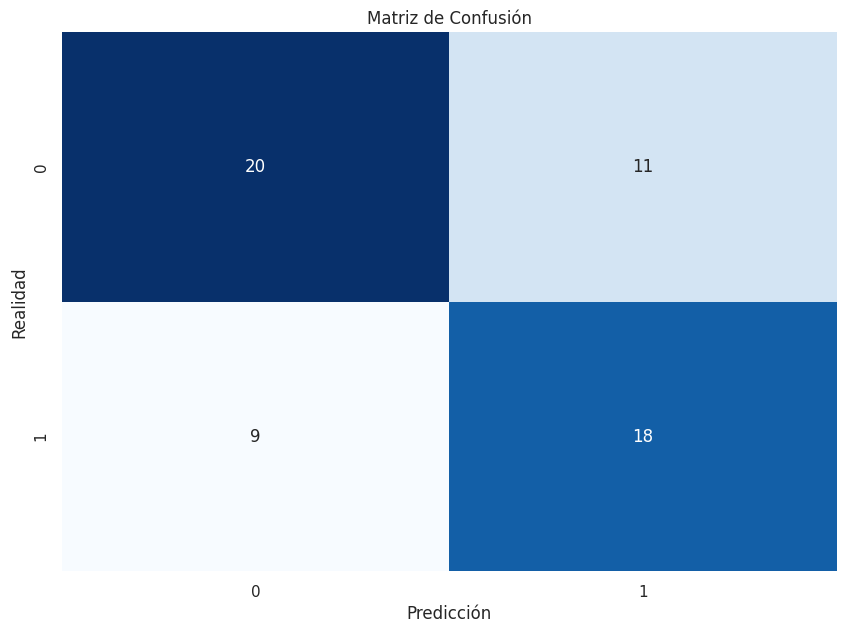

Banda: AL1
Accuracy: 0.6545454545454545
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.55      0.56        22
           1       0.71      0.73      0.72        33

    accuracy                           0.65        55
   macro avg       0.64      0.64      0.64        55
weighted avg       0.65      0.65      0.65        55

Matthews Correlation Coefficient: 0.27500954910846337
F1 Score: 0.6531065602221451
Precision: 0.6521008403361345
Recall: 0.6545454545454545


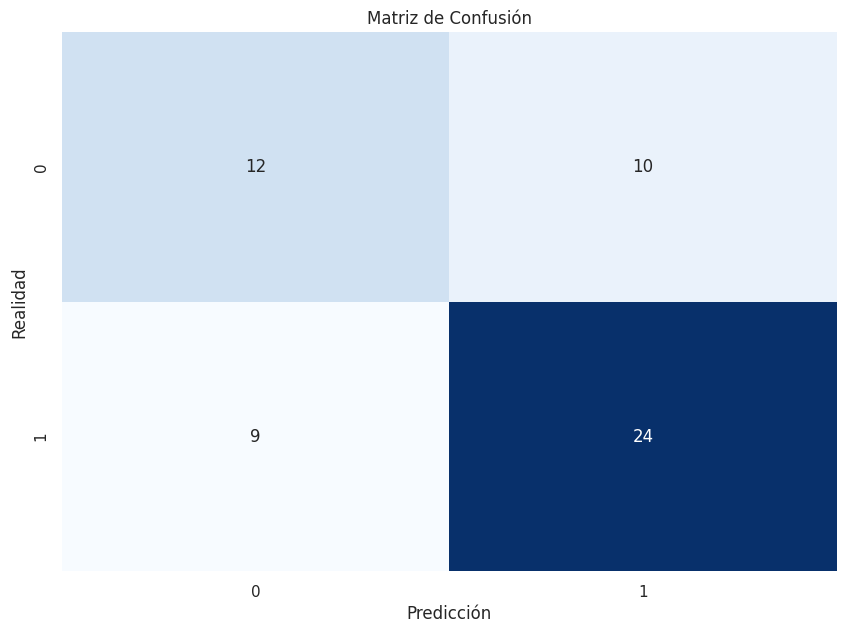

Banda: GM
Accuracy: 0.5636363636363636
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.38      0.48        29
           1       0.53      0.77      0.62        26

    accuracy                           0.56        55
   macro avg       0.59      0.57      0.55        55
weighted avg       0.59      0.56      0.55        55

Matthews Correlation Coefficient: 0.160478217104117
F1 Score: 0.5476284584980238
Precision: 0.5899802983394314
Recall: 0.5636363636363636


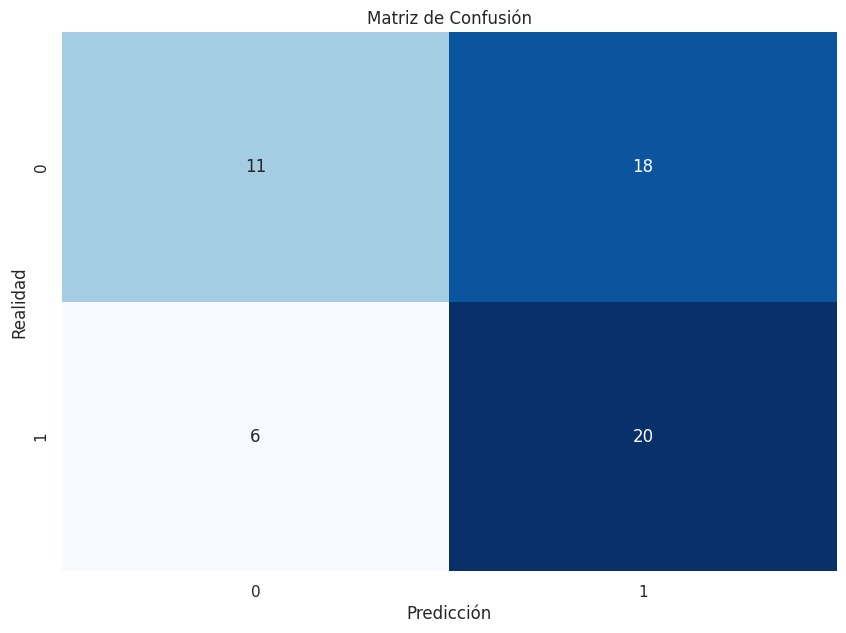

Banda: AL2
Accuracy: 0.7115384615384616
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.77      0.73        26
           1       0.74      0.65      0.69        26

    accuracy                           0.71        52
   macro avg       0.71      0.71      0.71        52
weighted avg       0.71      0.71      0.71        52

Matthews Correlation Coefficient: 0.4259217009643015
F1 Score: 0.7105751391465678
Precision: 0.7143928035982009
Recall: 0.7115384615384616


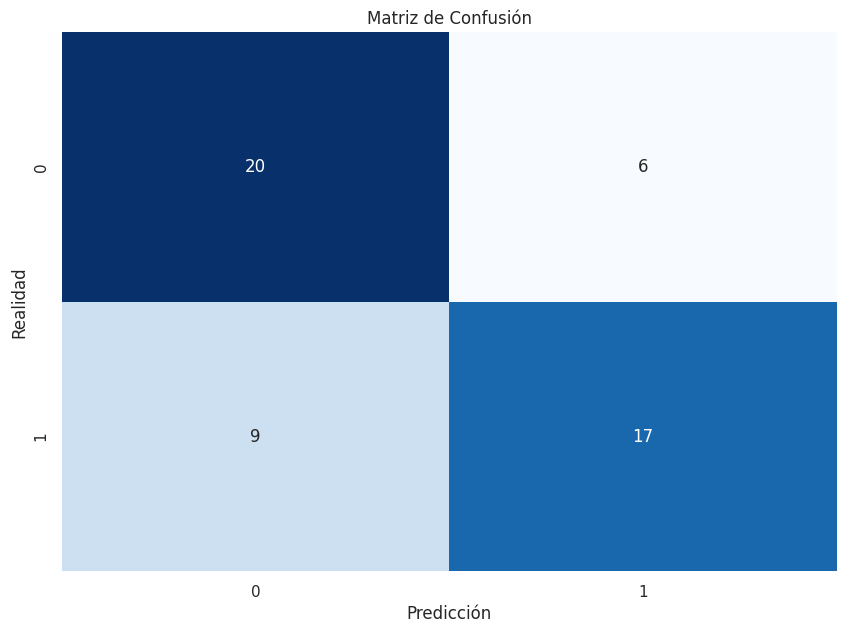

Banda: TH
Accuracy: 0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.47      0.63        36
           1       0.41      0.93      0.57        14

    accuracy                           0.60        50
   macro avg       0.68      0.70      0.60        50
weighted avg       0.79      0.60      0.61        50

Matthews Correlation Coefficient: 0.37490813101603976
F1 Score: 0.6115942028985508
Precision: 0.79375
Recall: 0.6


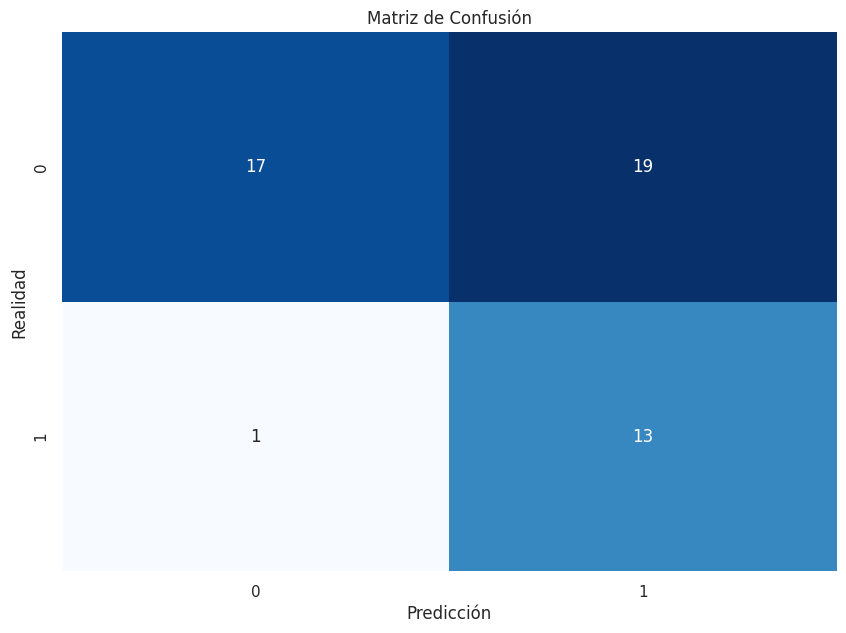

Banda: GM2
Accuracy: 0.7446808510638298
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80        32
           1       0.58      0.73      0.65        15

    accuracy                           0.74        47
   macro avg       0.72      0.74      0.72        47
weighted avg       0.77      0.74      0.75        47

Matthews Correlation Coefficient: 0.45910450047444507
F1 Score: 0.7511889862327911
Precision: 0.7683570628699408
Recall: 0.7446808510638298


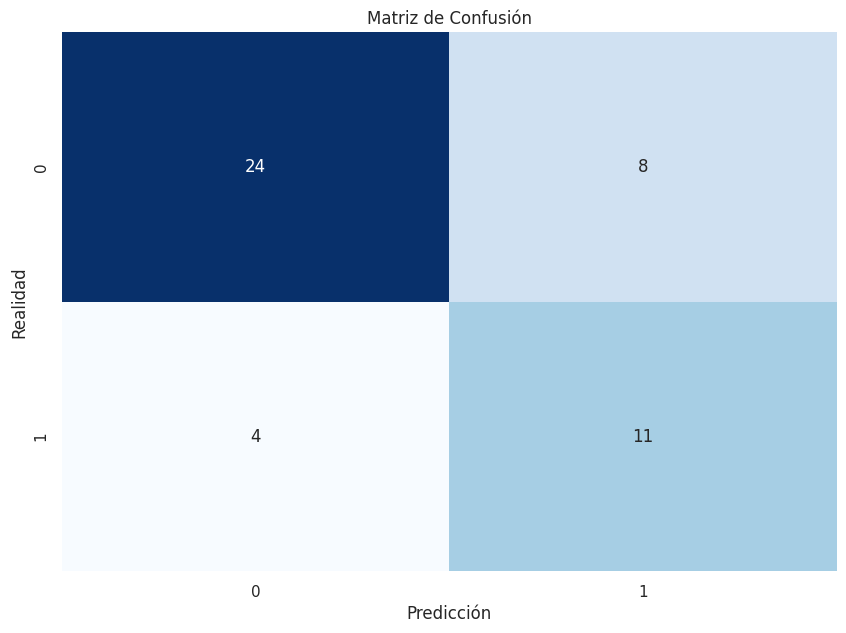

In [ ]:
lista_de_bandas = df_total['Banda'].unique()
lista_de_bandas = lista_de_bandas[:-1] 
for banda in lista_de_bandas:
    df_banda = df_total[df_total['Banda'] == banda]
    y_banda = df_banda['Real']
    X_banda = df_banda.drop(columns=['Real','Tipo','Condicion','Banda','Participantes','Grupo'])
    X_train_banda, X_test_banda, y_train_banda, y_test_banda = train_test_split(X_banda, y_banda, test_size=0.2)
    
    grid_search_svm.fit(X_train_banda, y_train_banda)
    y_pred_banda = grid_search_svm.predict(X_test_banda)
    print(f"Banda: {banda}")
    Guardar_metricas(resultados_modelos, grid_search_svm, y_test_banda, y_pred_banda, 'SVM', 'Banda: ' + banda)
    mostrar_metricas(y_test_banda, y_pred_banda)

#### Hacer modelo por condicion

Condición: OA
Accuracy: 0.5447154471544715
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.47      0.56        74
           1       0.45      0.65      0.53        49

    accuracy                           0.54       123
   macro avg       0.56      0.56      0.54       123
weighted avg       0.58      0.54      0.55       123

Matthews Correlation Coefficient: 0.12490259286049028
F1 Score: 0.5467028003613369
Precision: 0.5844894256093157
Recall: 0.5447154471544715


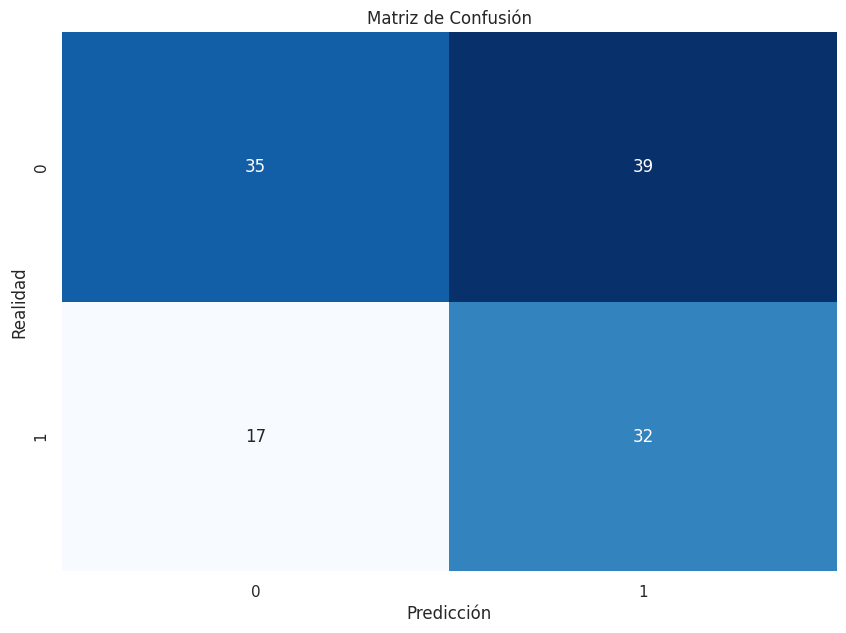

Condición: OC
Accuracy: 0.5289855072463768
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.50      0.53        74
           1       0.49      0.56      0.53        64

    accuracy                           0.53       138
   macro avg       0.53      0.53      0.53       138
weighted avg       0.53      0.53      0.53       138

Matthews Correlation Coefficient: 0.062440698948220096
F1 Score: 0.529208115576723
Precision: 0.5339472518745896
Recall: 0.5289855072463768


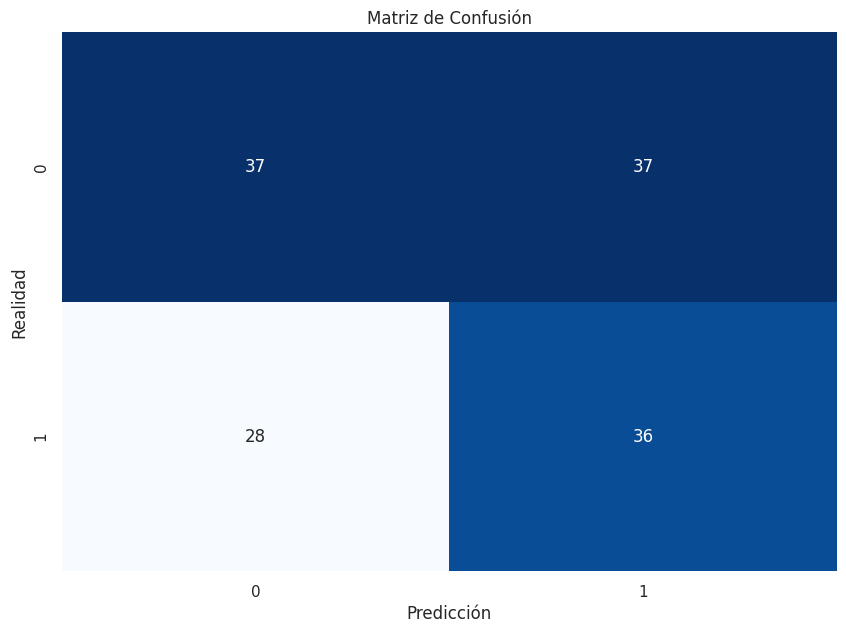

Condición: EX
Accuracy: 0.7581699346405228
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.67      0.73        75
           1       0.73      0.85      0.78        78

    accuracy                           0.76       153
   macro avg       0.77      0.76      0.76       153
weighted avg       0.77      0.76      0.76       153

Matthews Correlation Coefficient: 0.5221878717708698
F1 Score: 0.7559974017681188
Precision: 0.7650673172494804
Recall: 0.7581699346405228


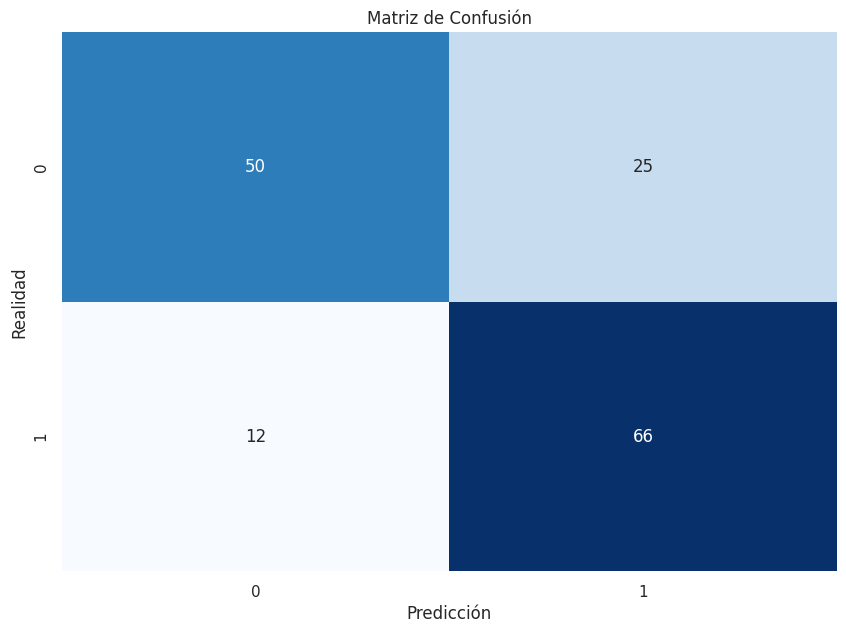

In [ ]:
lista_de_condiciones = df_total['Condicion'].unique()

for condicion in lista_de_condiciones:
    df_condicion = df_total[df_total['Condicion'] == condicion]
    y_condicion = df_condicion['Real']
    X_condicion = df_condicion.drop(columns=['Real','Tipo','Condicion','Banda','Participantes','Grupo'])
    X_train_condicion, X_test_condicion, y_train_condicion, y_test_condicion = train_test_split(X_condicion, y_condicion, test_size=0.2)
    
    grid_search_svm.fit(X_train_condicion, y_train_condicion)
    y_pred_condicion = grid_search_svm.predict(X_test_condicion)
    Guardar_metricas(resultados_modelos, grid_search_svm, y_test_condicion, y_pred_condicion, 'SVM', 'condicion: ' + condicion)
    print(f"Condición: {condicion}")
    mostrar_metricas(y_test_condicion, y_pred_condicion)

## Empezamos random forest

In [73]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='matthews_corrcoef', n_jobs=-1)

Accuracy: 0.6876513317191283
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.77      0.73       226
           1       0.68      0.58      0.63       187

    accuracy                           0.69       413
   macro avg       0.69      0.68      0.68       413
weighted avg       0.69      0.69      0.68       413

Matthews Correlation Coefficient: 0.36500211442311853
F1 Score: 0.6843025844678513
Precision: 0.686968185646336
Recall: 0.6876513317191283


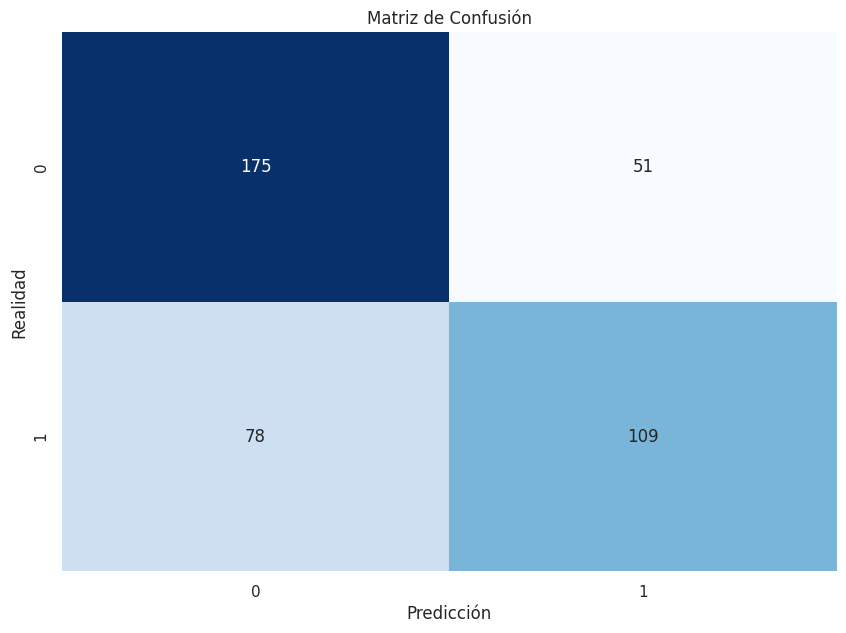

In [ ]:

y = df_total['Real']
X = df_total.drop(columns=['Real','Tipo','Condicion','Banda','Participantes','Grupo'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

grid_search_rf.fit(X_train,y_train)

y_pred_svm = grid_search_rf.predict(X_test)
mostrar_metricas(y_test, y_pred_svm)
Guardar_metricas(resultados_modelos, grid_search_rf, y_test, y_pred_svm, 'Random Forest', 'totales')


Banda: DL
Accuracy: 0.6346153846153846
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.82      0.71        28
           1       0.67      0.42      0.51        24

    accuracy                           0.63        52
   macro avg       0.64      0.62      0.61        52
weighted avg       0.64      0.63      0.62        52

Matthews Correlation Coefficient: 0.2619924972972864
F1 Score: 0.6177514792899408
Precision: 0.6424116424116424
Recall: 0.6346153846153846


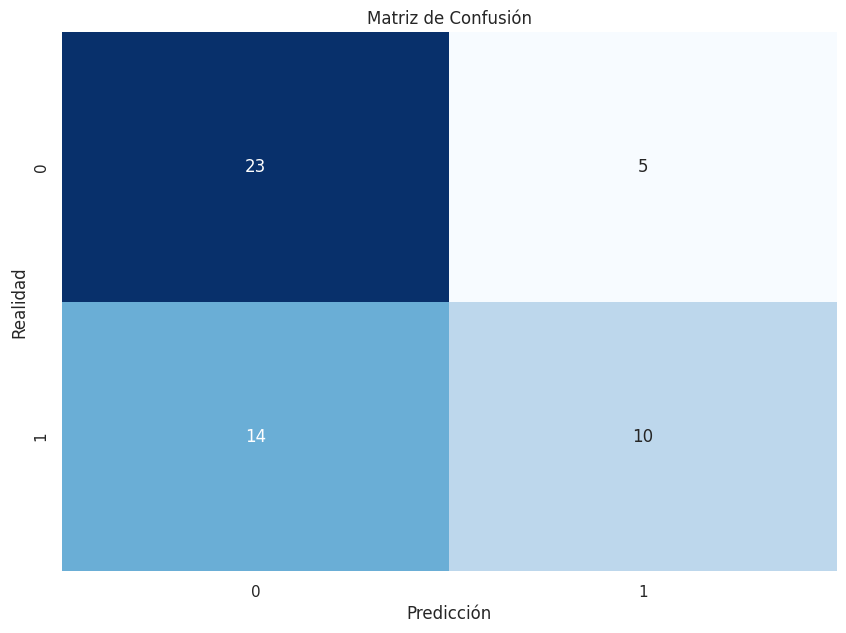

Banda: BT
Accuracy: 0.46551724137931033
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.60      0.49        25
           1       0.55      0.36      0.44        33

    accuracy                           0.47        58
   macro avg       0.48      0.48      0.46        58
weighted avg       0.49      0.47      0.46        58

Matthews Correlation Coefficient: -0.037113480951260276
F1 Score: 0.46026003391746745
Precision: 0.4899425287356322
Recall: 0.46551724137931033


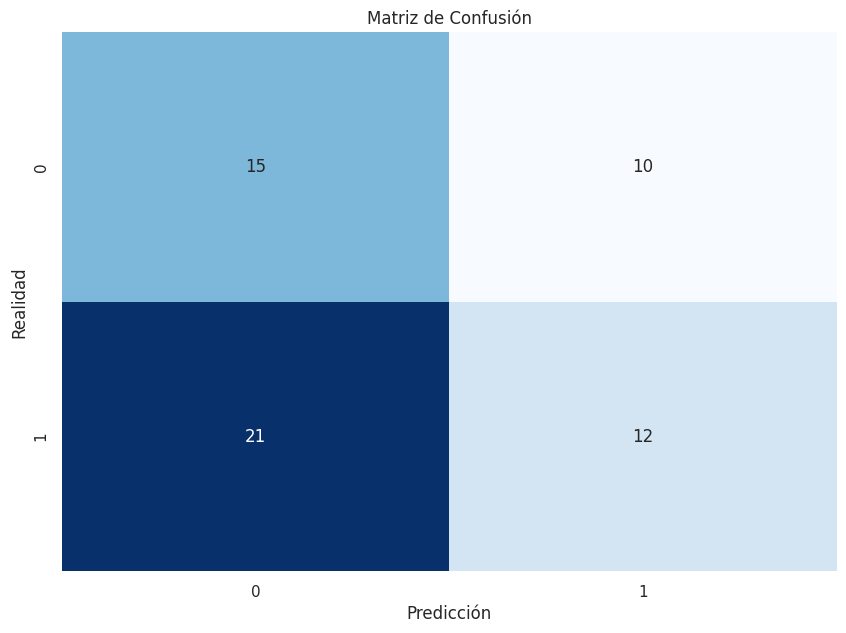

Banda: AL1
Accuracy: 0.5272727272727272
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.50      0.57        34
           1       0.41      0.57      0.48        21

    accuracy                           0.53        55
   macro avg       0.53      0.54      0.52        55
weighted avg       0.56      0.53      0.53        55

Matthews Correlation Coefficient: 0.06950809680196038
F1 Score: 0.5335757575757575
Precision: 0.5621895346033277
Recall: 0.5272727272727272


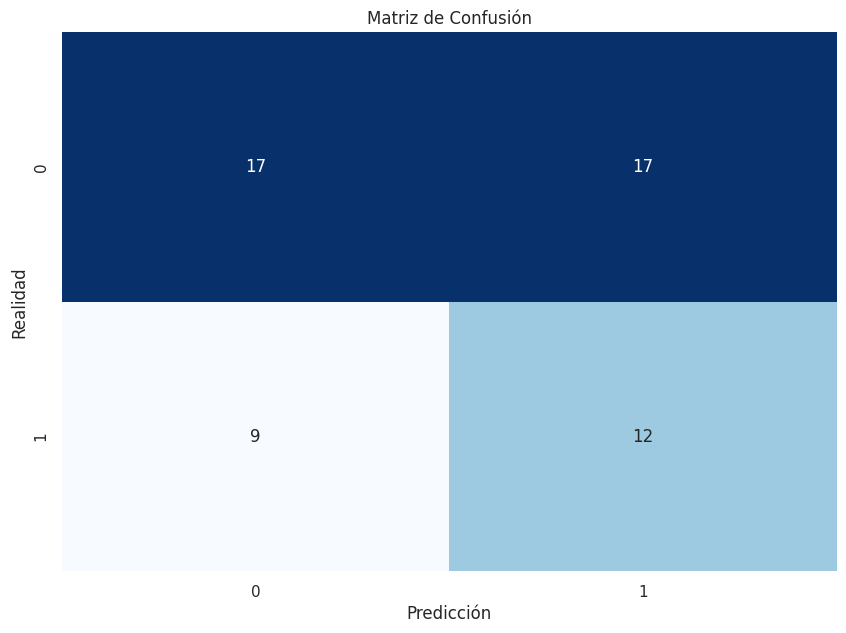

Banda: GM
Accuracy: 0.6545454545454545
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.73      0.67        26
           1       0.71      0.59      0.64        29

    accuracy                           0.65        55
   macro avg       0.66      0.66      0.65        55
weighted avg       0.66      0.65      0.65        55

Matthews Correlation Coefficient: 0.31909923295119014
F1 Score: 0.6534019439679818
Precision: 0.6632209188660801
Recall: 0.6545454545454545


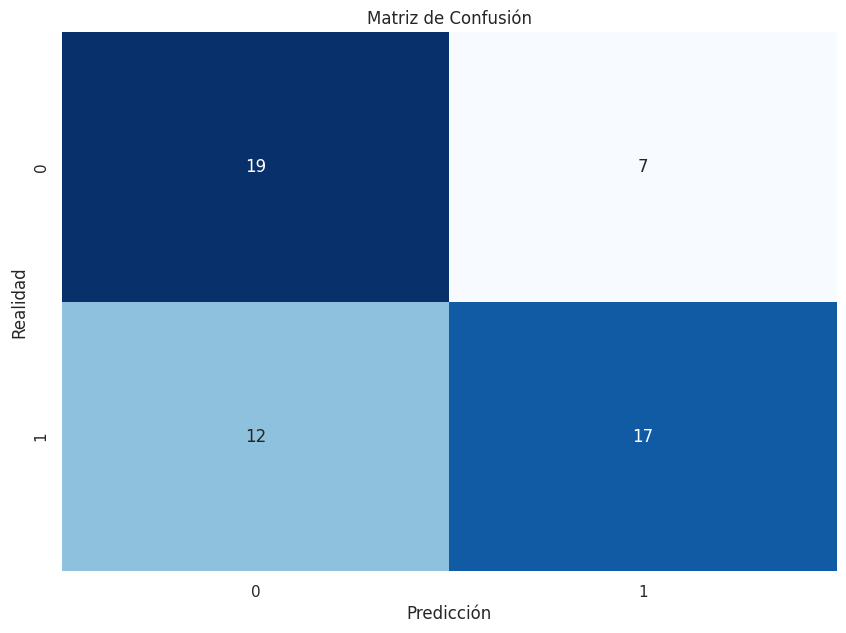

Banda: AL2
Accuracy: 0.7115384615384616
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.89      0.76        27
           1       0.81      0.52      0.63        25

    accuracy                           0.71        52
   macro avg       0.74      0.70      0.70        52
weighted avg       0.74      0.71      0.70        52

Matthews Correlation Coefficient: 0.44263520637871306
F1 Score: 0.7004824443848834
Precision: 0.7367788461538461
Recall: 0.7115384615384616


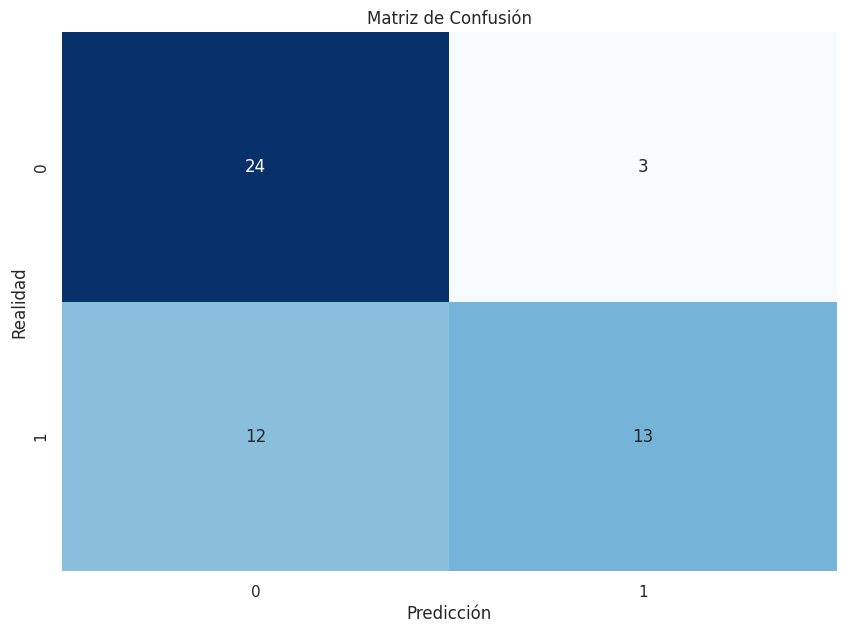

Banda: TH
Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.97      0.82        29
           1       0.91      0.48      0.62        21

    accuracy                           0.76        50
   macro avg       0.81      0.72      0.72        50
weighted avg       0.80      0.76      0.74        50

Matthews Correlation Coefficient: 0.5262777237215004
F1 Score: 0.7401470588235294
Precision: 0.7982284382284383
Recall: 0.76


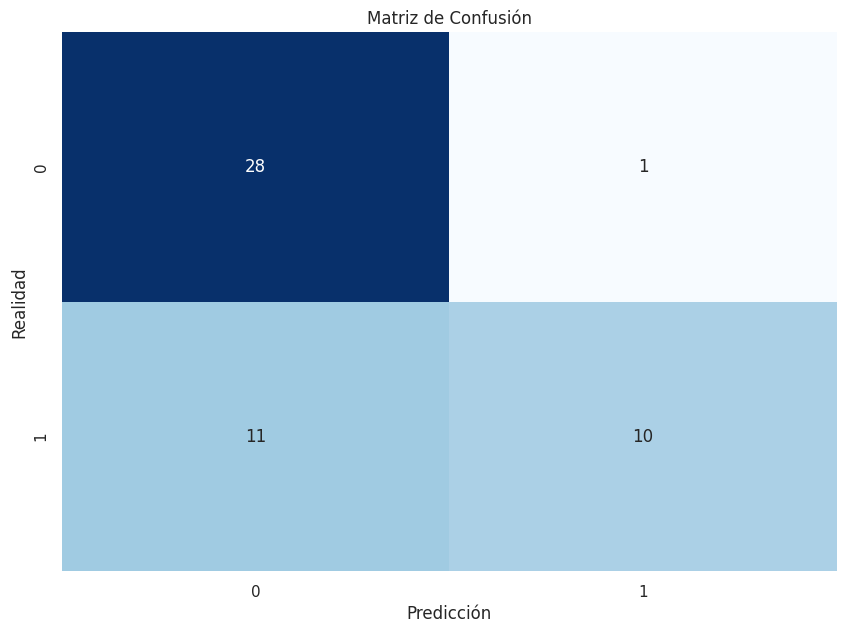

Banda: GM2
Accuracy: 0.7659574468085106
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.96      0.83        27
           1       0.91      0.50      0.65        20

    accuracy                           0.77        47
   macro avg       0.82      0.73      0.74        47
weighted avg       0.80      0.77      0.75        47

Matthews Correlation Coefficient: 0.5406242667788353
F1 Score: 0.7487008530248063
Precision: 0.8017408123791102
Recall: 0.7659574468085106


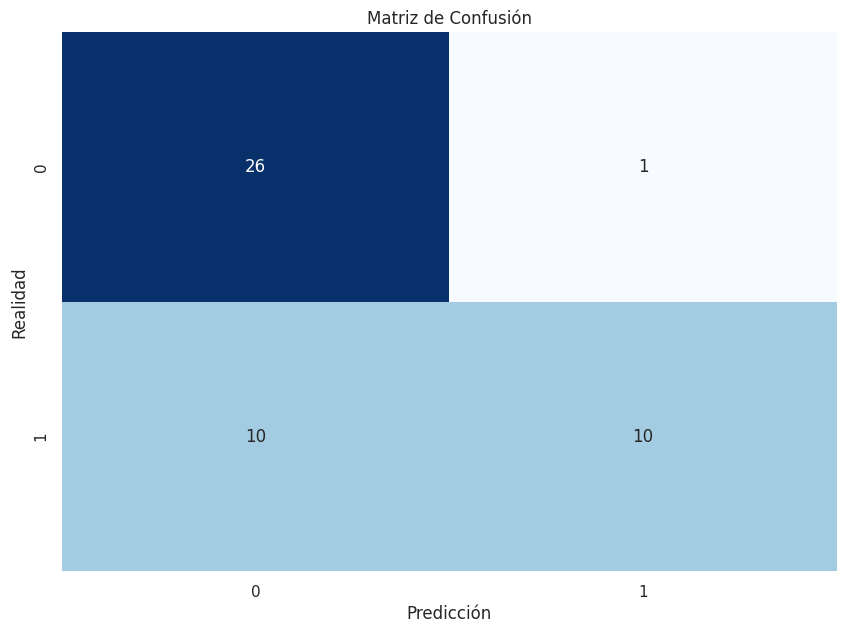

In [ ]:
lista_de_bandas = df_total['Banda'].unique()
#display(df_total.loc[df_total['Banda'] == 'AL2'])
lista_de_bandas = lista_de_bandas[:-1] # Excluir 'ALI(1)' de la lista, eliminando el ultimo elemote de la lista
for banda in lista_de_bandas:
    df_banda = df_total[df_total['Banda'] == banda]
    y_banda = df_banda['Real']
    X_banda = df_banda.drop(columns=['Real','Tipo','Condicion','Banda','Participantes','Grupo'])
    X_train_banda, X_test_banda, y_train_banda, y_test_banda = train_test_split(X_banda, y_banda, test_size=0.2)
    
    grid_search_rf.fit(X_train_banda, y_train_banda)
    y_pred_banda = grid_search_rf.predict(X_test_banda)
    print(f"Banda: {banda}")
    mostrar_metricas(y_test_banda, y_pred_banda)
    Guardar_metricas(resultados_modelos, grid_search_rf, y_test_banda, y_pred_banda, 'Random Forest', 'banda' + banda)

Condición: OA
Accuracy: 0.6910569105691057
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.91      0.78        74
           1       0.72      0.37      0.49        49

    accuracy                           0.69       123
   macro avg       0.70      0.64      0.63       123
weighted avg       0.70      0.69      0.66       123

Matthews Correlation Coefficient: 0.3318175478469354
F1 Score: 0.662512200231996
Precision: 0.6981450141032023
Recall: 0.6910569105691057


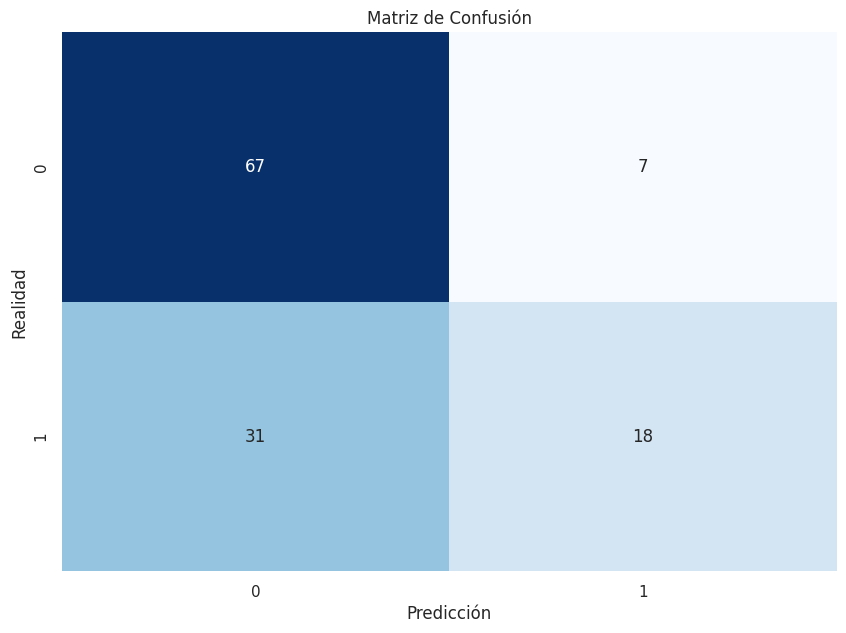

Condición: OC
Accuracy: 0.6304347826086957
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.71      0.68        75
           1       0.61      0.54      0.57        63

    accuracy                           0.63       138
   macro avg       0.63      0.62      0.62       138
weighted avg       0.63      0.63      0.63       138

Matthews Correlation Coefficient: 0.24989129875068836
F1 Score: 0.6278039324286901
Precision: 0.6284464475079533
Recall: 0.6304347826086957


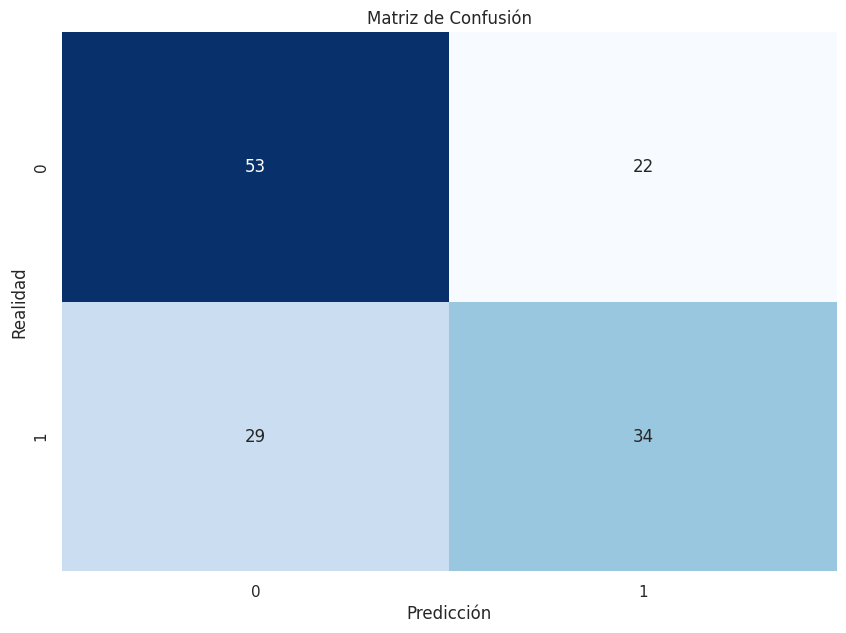

Condición: EX
Accuracy: 0.7254901960784313
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75        81
           1       0.73      0.67      0.70        72

    accuracy                           0.73       153
   macro avg       0.73      0.72      0.72       153
weighted avg       0.73      0.73      0.72       153

Matthews Correlation Coefficient: 0.44791400876468346
F1 Score: 0.7244245524296675
Precision: 0.7256131292642449
Recall: 0.7254901960784313


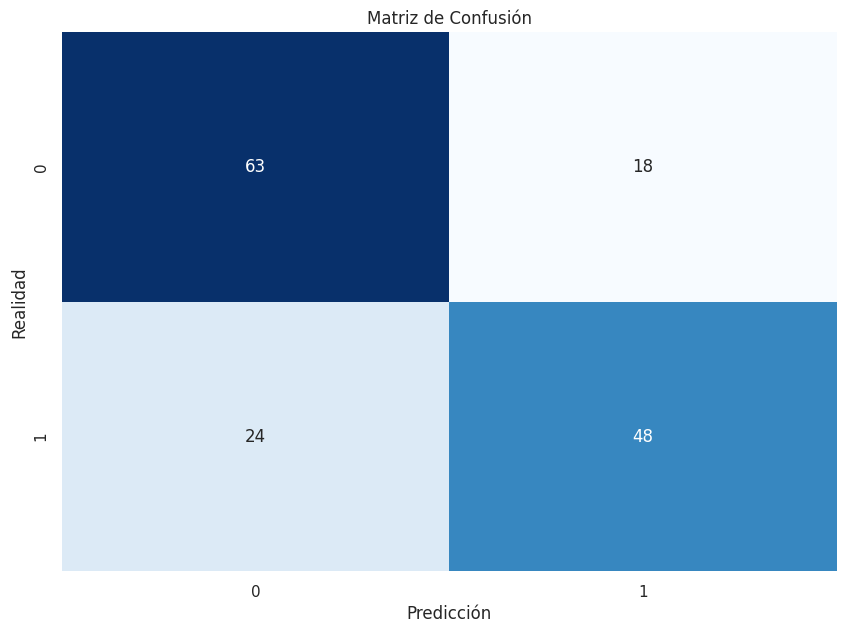

In [ ]:
lista_de_condiciones = df_total['Condicion'].unique()

for condicion in lista_de_condiciones:
    df_condicion = df_total[df_total['Condicion'] == condicion]
    y_condicion = df_condicion['Real']
    X_condicion = df_condicion.drop(columns=['Real','Tipo','Condicion','Banda','Participantes','Grupo'])
    X_train_condicion, X_test_condicion, y_train_condicion, y_test_condicion = train_test_split(X_condicion, y_condicion, test_size=0.2)
    
    grid_search_rf.fit(X_train_condicion, y_train_condicion)
    y_pred_condicion = grid_search_rf.predict(X_test_condicion)
    
    print(f"Condición: {condicion}")
    mostrar_metricas(y_test_condicion, y_pred_condicion)
    Guardar_metricas(resultados_modelos, grid_search_rf, y_test_condicion, y_pred_condicion, 'Random Forest', 'condicion: ' + condicion)

In [77]:
display(pd.DataFrame(resultados_modelos))

,Modelo,situación,Mejores Parámetros,Mejor Accuracy (validación),Accuracy (test),F1-Score (test),Matthews Correlation Coefficient (test),Recall
0,Logistic Regression,Totales,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.000000,0.566586,0.000000,0.000000,0.566586
1,Logistic Regression,Banda: DL,"{'C': 10, 'penalty': 'l1', 'solver': 'saga'}",0.077415,0.566586,0.000000,0.000000,0.566586
2,Logistic Regression,Banda: BT,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.000000,0.566586,0.000000,0.000000,0.566586
3,Logistic Regression,Banda: AL1,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.047742,0.566586,0.000000,0.000000,0.566586
4,Logistic Regression,Banda: GM,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.130283,0.566586,0.000000,0.000000,0.566586
5,Logistic Regression,Banda: AL2,"{'C': 10, 'penalty': 'l1', 'solver': 'saga'}",0.044839,0.566586,0.000000,0.000000,0.566586
6,Logistic Regression,Banda: TH,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.007719,0.566586,0.000000,0.000000,0.566586
7,Logistic Regression,Banda: GM2,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.000000,0.566586,0.000000,0.000000,0.566586
8,Logistic Regression,Condicion: OA,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.019725,0.487805,0.307692,-0.091077,0.487805
9,Logistic Regression,Condicion: OC,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.060500,0.601449,0.573643,0.201079,0.601449
